## Regularized maximum likelihood (RML) imaging of sub-mm interferometric data using the MPol package

### Introduction

This notebook demonstrates the use of the *MPol* package to perform regularised maximum likelihood (RML) imaging of sub-mm interferometric data.\
We list and implement the different practical steps involved in practically setting up the RML imaging process using Mpol.\
The focus of the notebook is to attempt to use this package to reconstuct images of AGB stellar atmospheres observed using the Atacama Large Millimeter/submillimeter Array (ALMA).\
The MPol package documentation and tutorials are available at: https://mpol-dev.github.io/MPoL/index.html

### To do:

1. Extract visibilities from CASA MS to .npz files readable by MPol
2. Find how to image a multi-channel visibility dataset into a continuum using MPol.
3. Add regularizers to the loss function.
4. Generate power spectrum from visibilities
5. Make various plotms style plots of the visibilities in python (checkout modules in *SMILI* and *eht_imaging*)

### Importing modules

In [341]:
import numpy as np

# redefining np.asscalar() and np.alen() to np.item() and np.len() to avoid deprecation errors
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
def patch_asscalar(a):
    return a.item()
setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.len()
setattr(np, "alen", patch_alen)
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###

import torch
import matplotlib.pyplot as plt
from astropy.utils.data import download_file

from PIL import Image, ImageOps, ImageMath

# Mpol utilities
from mpol.__init__ import zenodo_record
from mpol import coordinates, gridding, fourier, losses, precomposed, utils
from mpol.images import ImageCube

### Getting the observed visibilities #**TODO**

These are needed in a file of **.npz** format. \
For the actual data, this can be obtained from a calibrated MS using **casatools/visread** within python.\
(See: https://mpol-dev.github.io/visread/tutorials/introduction_to_casatools.html#exporting-visibilities)\

#TODO:
1. Look into how to properly extract this for a continuum cube of multiple channels.
2. Check out *SMILI* and *eht-imaging*, which can load **uvfits** files containing the visibilities.
3. Check out the **pyuvdata** package for handling uv-data. (See: https://pyuvdata.readthedocs.io/en/v2.3/index.html)

### Loading pre-prepared visibility datasets: Reading **.npz** file

In [342]:
# example: ALMA logo

# Download the data: pre-converted to visibilities
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# Use only channel 4 from the downloaded data cube
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = np.real(data)
data_im = np.imag(data)

nchan = 1

nvis = uu.shape
print("Dataset has {:} channels".format(nchan))
print("Dataset has {:} visibilities".format(nvis))

Dataset has 1 channels
Dataset has (325080,) visibilities


### Creating mock visibilities from a model image: Using **mpol.fourier.make_fake_data()** [NuFFT]

(See: https://mpol-dev.github.io/MPoL/ci-tutorials/fakedata.html)\
The linked tutorial uses an image of the ALMA array. We will try to use a model image of a star instead.

In [343]:
# load the image (of the sky brightness distribution model) using the pillow library
im_raw = Image.open('../data/star_images/model_star_new.jpeg')

# convert the image to single axis greyscale from RGB, etc.
im_grey = ImageOps.grayscale(im_raw)
print(im_grey.mode)

# get image dimensions
xsize, ysize = im_grey.size
print(xsize, ysize)

L
128 128


##### Additional tasks:

1. Apodize the image if edges are not zero.
2. Pad the image so that it becomes square, if not already.
3. Resize the image to have less number of pixels if npix is too large.

For examples of how to perform these tasks, see: https://mpol-dev.github.io/MPoL/ci-tutorials/fakedata.html

In [344]:
# Additional tasks: optional for model star image

# xhann = np.hanning(xsize)
# yhann = np.hanning(ysize)
# # each is already normalized to a max of 1
# # so hann is also normed to a max of 1
# # broadcast to 2D
# hann = np.outer(yhann, xhann)

# # now convert the numpy array to a Pillow object
# # scale to 0 - 255 and then convert to uint8
# hann8 = np.uint8(hann * 255)
# im_apod = Image.fromarray(hann8)

# im_res = ImageMath.eval("a * b", a=im_grey, b=im_apod)#.rotate(90)

# max_dim = np.maximum(xsize, ysize)
# im_pad = ImageOps.pad(im_res, (max_dim, max_dim))

# npix = 128
# im_grey = im_pad.resize((npix,npix))

# im_grey

##### Setting the flux scale of the image
(The ImageCube object will expect the input tensor to be in units of **Jy/arcsec^2**)

In [345]:
# obtain the pixel values of the greyscale image as a numpy array
im_array = np.array(im_grey)
im_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

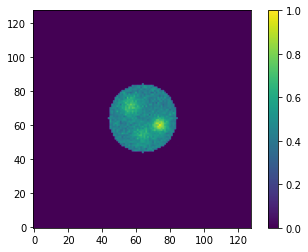

In [346]:
# convert this array to a float64 type and normalize its max value to 1
im_array = im_array.astype("float64")
im_array = im_array/im_array.max()

# flipping the image to prevent it from being flipped when visualized with imshow(origin='lower')
im_array = np.flipud(im_array)

# visualise the image
plt.imshow(im_array, origin='lower')
plt.colorbar()
plt.show()

In [347]:
# convert single channel image to a 3D imager cube (add a dimension of size 1)
im_cube = np.expand_dims(im_array, axis=0)
im_cube

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

#**NOTE**:\
Adjusting the cell_size changes the maximum spatial frequency that can be represented in the image.\
i.e., a smaller pixel cell_size will enable an image to carry higher spatial frequencies.\
Changing the number of pixels in the image via npix will change the number of cells between 0 and the max spatial frequency.\
We effectively chose the npix when we performed the resize operation, so all that’s left is to choose the cell_size.

In [348]:
# choose how big we want our mock sky brightness to be on the sky (setting cell size and npix)
cell_size = 0.03 # arcsec

# calculate the number of pixels per image axis
npix = im_array.shape[0]
print(npix)

# calculate the area per pixel in the image
pixel_area = cell_size**2 # arcsec
print(pixel_area, "arcsec^2")

128
0.0009 arcsec^2


If the image is supposed to be in Jy/arcsec^2, then to calculate original total flux in Jy, we would convert to Jy/pixel by multiplying the image with the area-per-pixel and then summing all values.

In [349]:
# calculate the total flux in the original image
original_flux = np.sum(im_cube * pixel_area)
print(original_flux, "Jy")

0.5651362204724408 Jy


Let us say we want the image to have a total flux of 5 Jy. Then, we would multiply the image by 5/original_flux, where original_flux is the sum of all pixel values in the image.

In [350]:
# scale the image so that the total flux becomes 'new_flux' Jy
new_flux = 5 # Jy
im_cube_flux_scaled = im_cube * (new_flux/original_flux)
scaled_flux = np.sum(im_cube_flux_scaled * pixel_area)
print(scaled_flux, "Jy")
print(im_cube_flux_scaled, "Jy")

5.000000000000002 Jy
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] Jy


In [351]:
# convert the image cube array to a torch tensor
img_tensor = torch.tensor(im_cube_flux_scaled.copy())
img_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)

5.000000000000002


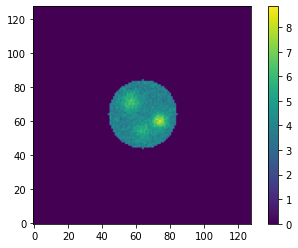

In [352]:
# shift the tensor from a “Sky Cube” to a “Packed Cube” as the input to mpol.images.ImageCube() which will be FFT’ed to get the visibilities is a “Packed Cube” object
img_tensor_packed = utils.sky_cube_to_packed_cube(img_tensor)

# create an MPol "Image Cube" object
image = ImageCube.from_image_properties(cell_size=cell_size, npix=npix, nchan=1, cube=img_tensor_packed)

# double check if the image cube is as expected: check if it has the same scaled flux
print(np.sum(np.squeeze(utils.packed_cube_to_sky_cube(image()).detach().numpy()) * pixel_area))
# double check if the image cube is as expected: convert back to numpy array and visualise
plt.imshow(np.squeeze(utils.packed_cube_to_sky_cube(image()).detach().numpy()), origin="lower")
plt.colorbar()
plt.show()

In [353]:
# obtain a (u,v) distribution (and weights) on which to calculate the visibilities of the image (download from MPol ALMA logo tutorial)

# download the ALMA logo mock visibility dataset
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# select the components for a single channel
chan = 4

# extract the (u,v) distribution and weights from the downloaded data
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]

nvis = uu.shape[0]
print(f"Dataset has {nvis} visibilities")

print(uu)
print(vv)
print(weight)

Dataset has 325080 visibilities
[   81.49899897     7.87458415   -52.21522451 ...  2219.99621332
  1180.43683531 -1039.55937801]
[   15.83280024    27.80872902   -44.83083149 ...   774.43215868
  -261.48392316 -1035.91608184]
[0.46612835 0.46612835 0.46612835 ... 0.46612835 0.46612835 0.46612835]


See: https://mpol-dev.github.io/MPoL/ci-tutorials/gridder.html#plotting-the-data

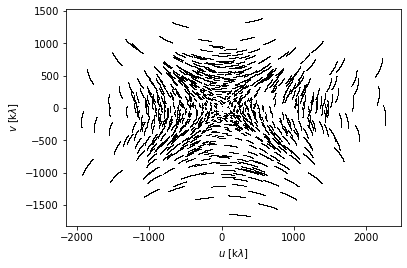

In [354]:
# Plot the downloaded (u,v) distribution
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
plt.show()

In [355]:
max_uv = np.max(np.array([uu,vv]))
max_cell_size = utils.get_maximum_cell_size(max_uv)
print("The maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is {:.2f} arcseconds".format(max_cell_size))
assert cell_size < max_cell_size

The maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is 0.09 arcseconds


With the ImageCube, (u,v), and weight distributions now in hand, generating the mock visibilities is relatively straightforward using the mpol.fourier.make_fake_data() routine.\
This routine uses the NuFFT to produce loose visibilities at the (u,v) locations and then adds random Gaussian noise to the visibilities, drawn from a probability distribution set by the value of the weights.

In [356]:
# create the mock visibilities corresponding to the image (having the same shape as the uu, vv, and weight inputs)
data_noise, data_noiseless = fourier.make_fake_data(image, uu, vv, weight)

print(data_noise.shape)
print(data_noiseless.shape)
print(data_noise)

(1, 325080)
(1, 325080)
[[ 4.34067554-0.32198789j  8.43002687-1.44852313j  5.38217325+1.72398064j
  ...  0.58454682-0.21437573j -0.91657535+0.62208221j
  -0.13306346-1.67643486j]]


In [357]:
# save the mock visibilities to a .npz file
data = np.squeeze(data_noise)
np.savez("../data/visibilities/mock_visibilities_model_star_new.npz", uu=uu, vv=vv, weight=weight, data=data)

### Generating the dirty image from the loaded visibilities

For loading visibilities from .npz files, see: https://mpol-dev.github.io/MPoL/ci-tutorials/gridder.html#importing-data\
For plotting the visibilitiy data, see: https://mpol-dev.github.io/MPoL/ci-tutorials/gridder.html#plotting-the-data

In [358]:
# load the mock visibilities from the .npz file (we will use the mock visibilities of the model star image)
d = np.load("../data/visibilities/mock_visibilities_model_star_new.npz")
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

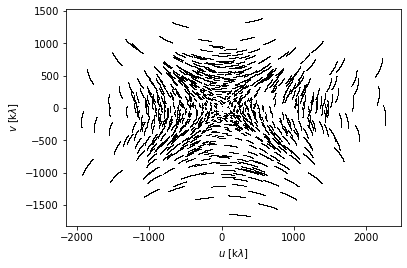

In [359]:
# Plot the downloaded (u,v) distribution
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
plt.show()

See: https://mpol-dev.github.io/MPoL/ci-tutorials/gridder.html#plotting-the-data

#TODO:
1. Make various plotms style plots of the visibilities in python (checkout modules in *SMILI* and *eht_imaging*).

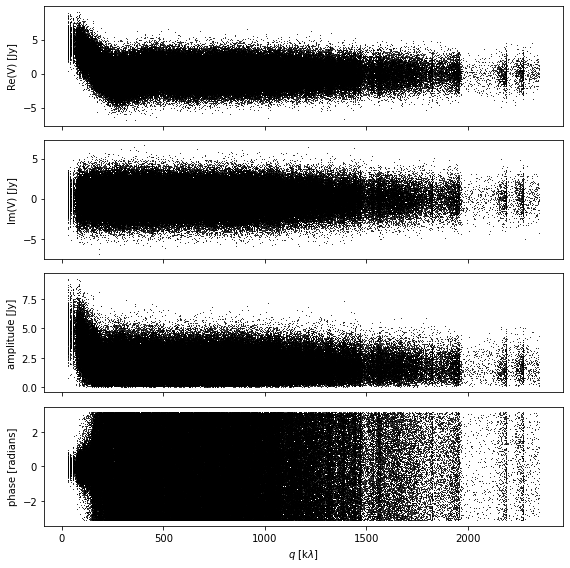

In [360]:
#calculate the amplitude and phase of the visibilities
amp = np.abs(data)
phase = np.angle(data)

# calculate the uv distance (baseline separations in meters, calculated as sqrt(u*u+v*v))
uvdist = np.hypot(uu, vv)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
pkw = {"s":1, "rasterized":True, "linewidths":0.0, "c":"k"}

ax[0].scatter(uvdist, data.real, **pkw)
ax[0].set_ylabel("Re(V) [Jy]")

ax[1].scatter(uvdist, data.imag, **pkw)
ax[1].set_ylabel("Im(V) [Jy]")

ax[2].scatter(uvdist, amp, **pkw)
ax[2].set_ylabel("amplitude [Jy]")

ax[3].scatter(uvdist, phase, **pkw)
ax[3].set_ylabel("phase [radians]")
ax[3].set_xlabel(r"$q$ [k$\lambda$]")

plt.tight_layout()
plt.show()

The **mpol.coordinates.gridcoords** object:\
Two numbers, cell_size and npix, uniquely define a grid in image space and in Fourier space.\
The mpol.coordinates.GridCoords object is mainly a container for all of the information about this grid.\
It uses desired image dimensions (via the cell_size and npix arguments) to define a corresponding Fourier plane grid.\
**coords.img_ext** gives the *extent* parameter for plt.imshow() to plot the image.\
See: https://mpol-dev.github.io/MPoL/api.html#mpol.coordinates.GridCoords\
and also: https://mpol-dev.github.io/MPoL/ci-tutorials/gridder.html#the-gridcoords-object

The **mpol.gridding.DirtyImager** object:\
Instantiating the DirtyImager object attaches the GridCoords object and the loose visibilities.\
The mpol.gridding.DirtyImager.get_dirty_image() routine will average, or ‘grid’, the loose visibilities to the Fourier grid defined by GridCoords.\
See: https://mpol-dev.github.io/MPoL/api.html#mpol.gridding.DirtyImager\
It will then calculate the diagnostic dirty image and dirty beam cubes that correspond to the Fourier transform of the gridded visibilities, using the **mpol.gridding.DirtyImager.get_dirty_image()** routine\
Weighting and tapering can be applied to the visibilities in this routine.\
See: https://mpol-dev.github.io/MPoL/api.html#mpol.gridding.DirtyImager.get_dirty_image

In [361]:
# instantiate the gridcoords object
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)

# instantiate the dirty imager object
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=np.real(data),
    data_im=np.imag(data),
)

# calculate the dirty image and the beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)

print(beam.shape)
print(img.shape)

(1, 128, 128)
(1, 128, 128)


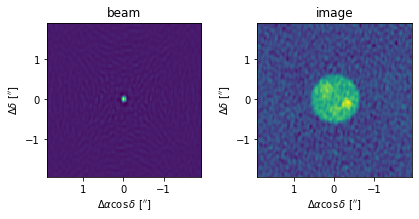

In [362]:
# visualise the calculated dirty image and dirty beam
chan = 0
kw = {"origin": "lower", "interpolation": "none", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].imshow(beam[chan], **kw)
ax[0].set_title("beam")
ax[1].imshow(img[chan], **kw)
ax[1].set_title("image")
for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.tight_layout()
plt.show()

The **mpol.gridding.DataAverager()** object:
Grids the loose visibilities to the Fourier grid defined by GridCoords, as done by the **DirtyImager** object.\
See: https://mpol-dev.github.io/MPoL/api.html#mpol.gridding.DataAverager\
Then, it can use the **mpol.gridding.DataAverager.to_pytorch_dataset()** routine to convert the gridded visibilities to a PyTorch dataset.\
See: https://mpol-dev.github.io/MPoL/api.html#mpol.gridding.DataAverager.to_pytorch_dataset\
This gridded visibility dataset in  pytorch format can later be used to calculate likelihoods and in the imaging loop.

In [363]:
# instantiate the data averager object
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
    )

# convert the gridded to a pytorch dataset
dset = averager.to_pytorch_dataset()

print(f"this dataset has {dset.nchan} channel(s)")

this dataset has 1 channel(s)


### The imaging workflow

##### The SimpleNet meta-module

The **mpol.precomposed.SimpleNet()** meta-module is a network of the following datasets:

1. **BaseCube**: A base cube of the same dimensions as the image cube.\
Designed to use a pixel mapping function from the base cube values to the ImageCube domain. [I = f_map(b)]

2. **HannConvCube**: This convolutional layer convolves an input cube by a small (3x3) filter.\
This filter is the 2D version of the discretely-sampled response function corresponding to a Hann window, i.e., it is two 1D Hann windows multiplied together.\
This is a convolutional kernel in the image plane, and so effectively acts as apodization by a Hann window function in the Fourier domain.\
The idea is that this layer would help naturally attenuate high spatial frequency artifacts by baking in a natural apodization in the Fourier plane.

3. **ImageCube**: The parameter set is the pixel values of the image cube itself.\
The pixels are assumed to represent samples of the specific intensity and are given in units of Jy/arcsec^2.

4. **FourierCube**: This layer performs the FFT of an ImageCube and stores the corresponding dense FFT output as a gridded cube.

The **forward()** method:\
Feed forward to calculate the model visibilities. In this step, a BaseCube is fed to a HannConvCube is fed to a ImageCube is fed to a FourierCube to produce the visibility cube.

**NOTE**: The **loss function** is calculated between the **FourierCube** and the **gridded observed visibility dataset**, produced by **mpol.gridding.DataAverager.to_pytorch_dataset()**.\
**NOTE**: Our **model parameters** are the pixel values of the image.

**NOTE**: By default, the SimpleNet object sets up a **flat** BaseCube.

![The imaging workflow](Tutorial_images/imaging_workflow.png)

##### Packing cubes

Numerical FFT routines expect that the first element of an input array (i.e., array[i,0,0]) corresponds to the zeroth spatial (l,m) or frequency (u,v) coordinate.\
But normally, in our datasets, the zeroth spatial component is in the center of the array (at position array[i,M/2,L/2])\
In addition, astronomers usually plot images as seen on the sky: with north (m) up and east (l) to the left.\
Throughout the MPoL base, we call these cubes ‘sky cubes,’ see the above figure for a representation.

Packed sky cube, packed visibility cube, sky cube, and ground visibility cube:\
See: https://mpol-dev.github.io/MPoL/units-and-conventions.html#image-cube-packing-for-ffts\

![Cube packing](Tutorial_images/cube_packing_chart.png)

##### Initialising the SimpleNet Network

In [396]:
# initialise SimpleNet
rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)

# Because we want to compute a clean set of gradient values in a later step, we “zero out” any gradients attached to the tensor components so that they aren’t counted twice.
rml.zero_grad()

rml

SimpleNet(
  (bcube): BaseCube(
    (pixel_mapping): Softplus(beta=1, threshold=20)
  )
  (conv_layer): HannConvCube(
    (m): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (icube): ImageCube()
  (fcube): FourierCube()
)

As we have not run the training loop (SGD optimization) yet, the model parameters are still in the initial state.\
This means that the BaseCube is a flat image, as mentioned above, depicting the state of the parameters at the start of optimization.

In [397]:
# display the current parameters of the model
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       ...,
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

In [420]:
# extracting the BaseCube from the 'rml' SimpleNet network
rml.bcube.base_cube

Parameter containing:
tensor([[[1.7739, 1.7725, 1.8014,  ..., 1.8066, 1.7977, 1.7877],
         [1.7782, 1.7806, 1.8202,  ..., 1.8005, 1.8011, 1.7935],
         [1.7864, 1.7946, 1.8423,  ..., 1.7928, 1.8045, 1.8007],
         ...,
         [1.7831, 1.7501, 1.7352,  ..., 1.8755, 1.8548, 1.8218],
         [1.7746, 1.7555, 1.7555,  ..., 1.8458, 1.8251, 1.8005],
         [1.7726, 1.7648, 1.7802,  ..., 1.8209, 1.8045, 1.7889]]],
       dtype=torch.float64, requires_grad=True)

(1, 128, 128)


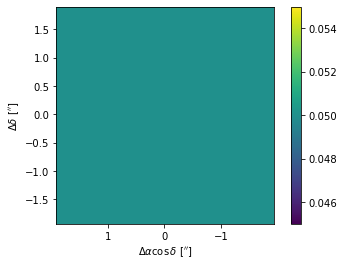

In [399]:
# visualise the (flat) base cube

# convert the 'packed' BaseCube to a SkyCube
bcube_pytorch = utils.packed_cube_to_sky_cube(rml.bcube.base_cube)

# bcube is still a PyTorch tensor, but matplotlib requires numpy arrays.
# To convert back, we need to first “detach” the computational graph from the PyTorch tensor (used to propagate gradients) and then call the numpy conversion routine.
bcube_numpy = bcube_pytorch.detach().numpy()
print(bcube_numpy.shape)

# remove the channel dimension (using  np.squeeze) and plot the 2D image
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(bcube_numpy),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)
plt.show()

##### The loss function

For RML imaging, the most fundamental **loss function** we’ll use is the **chi_sq** value comparing the *model visibilities* to the *data visibilities*.\
For now, we will just use this **negative-log-likelihood (nll)** [gridded] loss function.\
But because imaging is an ill-defined inverse problem, this is not a sufficient constraint by itself.\
Later, we have to apply regularization to narrow the set of possible images towards ones that we believe are more realistic.\
#**TODO**: Add regularizers to the loss function.\
See: https://mpol-dev.github.io/MPoL/api.html#module-mpol.losses

##### The training loop

Steps in the training loop:
1. Evaluate the current model against a loss function
2. Calculate the gradients of the loss w.r.t. the model
3. Advance the model parameters in the direction to minimize the loss function


The role of the optimizer is to advance the parameters (in this case, the pixel values of the mpol.images.BaseCube), using the gradient of the loss function with respect to those parameters.\
We are employing a **stochastic gradient descent (SGD)** optimizer from pytorch for this purpose.\
The *lr* parameter is the *learning rate* of the optimizer.

**Gradient Descent**:

Used to calculate the loss value and optimize the parameters by moving towards the minimum of the loss function.


In [400]:
# create the SGD optimizer
optimizer = torch.optim.SGD(rml.parameters(), lr=3.0e2)

##### Steps in the training loop

Most modules in MPoL are designed to work in a *“feed forward”* manner.\
This means base parameters are processed through the network to predict model visibilites for comparison with data.\
We can calculate the full visibility cube corresponding to the current pixel values of the mpol.images.BaseCube().

In [401]:
# STEP 1: calculate the model visibilities from the current model image (BaseCube)
vis = rml()
print(vis)

tensor([[[ 1.0512e+01+0.0000e+00j,  4.1197e-02+1.0113e-03j,
          -4.1122e-02-2.0202e-03j,  ...,
           4.0999e-02-3.0242e-03j, -4.1122e-02+2.0202e-03j,
           4.1197e-02-1.0113e-03j],
         [ 4.1197e-02+1.0113e-03j,  1.6136e-04+7.9272e-06j,
          -1.6097e-04-1.1874e-05j,  ...,
           1.6097e-04-7.9081e-06j, -1.6136e-04+3.9612e-06j,
           1.6156e-04-1.4832e-20j],
         [-4.1122e-02-2.0202e-03j, -1.6097e-04-1.1874e-05j,
           1.6049e-04+1.5807e-05j,  ...,
          -1.6097e-04+3.9517e-06j,  1.6126e-04-4.2154e-20j,
          -1.6136e-04-3.9612e-06j],
         ...,
         [ 4.0999e-02-3.0242e-03j,  1.6097e-04-7.9081e-06j,
          -1.6097e-04+3.9517e-06j,  ...,
           1.5904e-04-2.3591e-05j, -1.5981e-04+1.9711e-05j,
           1.6039e-04-1.5797e-05j],
         [-4.1122e-02+2.0202e-03j, -1.6136e-04+3.9612e-06j,
           1.6126e-04+2.4980e-20j,  ...,
          -1.5981e-04+1.9711e-05j,  1.6049e-04-1.5807e-05j,
          -1.6097e-04+1.1874e-05j],
 

In [402]:
# STEP 2: calculate the loss between the model visibilities and the data visibilities
loss = losses.nll_gridded(vis, dset) #NOTE: for now, the loss function is just the negative log likelihood (nll) only. Regularizers will be added later.
print(loss.item())

26.93139695799117


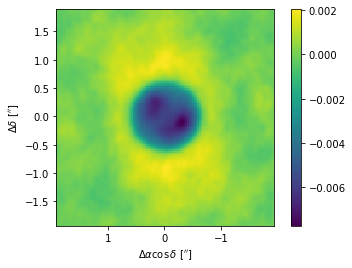

In [403]:
# STEP 3: calculate the gradients of the loss with respect to the model parameters
loss.backward()

# OPTIONAL: visualise the calculated gradients of the BaseCube
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(
        utils.packed_cube_to_sky_cube(rml.bcube.base_cube.grad).detach().numpy()
    ),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)

In [409]:
np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube.grad).detach().numpy())[60:68, 60:68]

array([[-0.00558483, -0.00560692, -0.00569595, -0.00584146, -0.00600193,
        -0.00612409, -0.00618305, -0.00622151],
       [-0.00563076, -0.00561725, -0.00566703, -0.00577696, -0.00590616,
        -0.00601603, -0.00608493, -0.00612842],
       [-0.00573819, -0.005685  , -0.005685  , -0.00574872, -0.00583515,
        -0.00591711, -0.00598594, -0.00603666],
       [-0.00586939, -0.00576739, -0.00571613, -0.0057419 , -0.00579638,
        -0.00584835, -0.00590299, -0.00595072],
       [-0.00599136, -0.00583804, -0.00574181, -0.00574638, -0.00579228,
        -0.0058258 , -0.00585541, -0.00588059],
       [-0.00609372, -0.00590074, -0.00576882, -0.00576062, -0.0058117 ,
        -0.00583712, -0.00583505, -0.0058194 ],
       [-0.006186  , -0.00597438, -0.00581519, -0.0057879 , -0.00583555,
        -0.0058485 , -0.00580932, -0.00574572],
       [-0.0062846 , -0.00607219, -0.00589282, -0.0058336 , -0.00585389,
        -0.00583594, -0.00575356, -0.00564701]])

In [415]:
np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube).detach().numpy())[60:68, 60:68]

array([[1.72544861, 1.73207746, 1.75878511, 1.80243785, 1.8505793 ,
        1.88722732, 1.90491448, 1.91645202],
       [1.73922842, 1.7351747 , 1.75010795, 1.78308931, 1.82184792,
        1.85480802, 1.8754793 , 1.88852671],
       [1.77145796, 1.75549901, 1.75550027, 1.77461514, 1.8005457 ,
        1.8251334 , 1.84578079, 1.86099808],
       [1.81081712, 1.78021666, 1.76483776, 1.77256937, 1.78891448,
        1.80450647, 1.8208963 , 1.83521551],
       [1.84740845, 1.80141072, 1.77254294, 1.7739137 , 1.78768419,
        1.79774018, 1.80662161, 1.81417753],
       [1.87811685, 1.82022066, 1.78064634, 1.77818496, 1.79350989,
        1.80113527, 1.80051483, 1.79582117],
       [1.9057996 , 1.84231257, 1.7945558 , 1.78637077, 1.80066645,
        1.80454912, 1.7927952 , 1.77371648],
       [1.93538146, 1.8716577 , 1.81784469, 1.80007869, 1.8061661 ,
        1.80078267, 1.77606944, 1.7441018 ]])

In [416]:
(1.72544861 - 0.05)/-0.00558483

-299.9999301679729

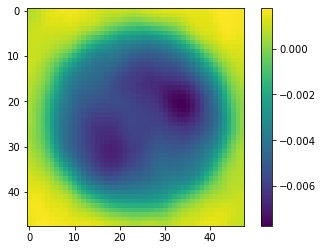

In [408]:
plt.imshow(np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube.grad).detach().numpy())[40:88, 40:88])
plt.colorbar()

In [410]:
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       ...,
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

In [387]:
-1.75505344e-06*300*300 + 0.05

-0.10795480959999999

#**NOTE**:\
The gradient image points in the direction of lower loss values.\
So the final step is to add the gradient image to the base image in order to advance base parameters in the direction of the minimum loss value.\
This process is called gradient descent.

In [411]:
# STEP 4: subtract the gradient image to the base image in order to advance base parameters in the direction of the minimum loss value
optimizer.step()

In [412]:
# print the updated paramter (pixel) values of the model image
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[1.7739, 1.7725, 1.8014,  ..., 1.8066, 1.7977, 1.7877],
                       [1.7782, 1.7806, 1.8202,  ..., 1.8005, 1.8011, 1.7935],
                       [1.7864, 1.7946, 1.8423,  ..., 1.7928, 1.8045, 1.8007],
                       ...,
                       [1.7831, 1.7501, 1.7352,  ..., 1.8755, 1.8548, 1.8218],
                       [1.7746, 1.7555, 1.7555,  ..., 1.8458, 1.8251, 1.8005],
                       [1.7726, 1.7648, 1.7802,  ..., 1.8209, 1.8045, 1.7889]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

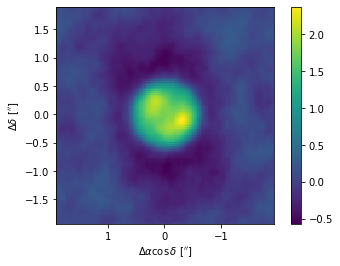

In [375]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube).detach().numpy()),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)

In [414]:
np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube).detach().numpy())[60:68, 60:68]

array([[1.72544861, 1.73207746, 1.75878511, 1.80243785, 1.8505793 ,
        1.88722732, 1.90491448, 1.91645202],
       [1.73922842, 1.7351747 , 1.75010795, 1.78308931, 1.82184792,
        1.85480802, 1.8754793 , 1.88852671],
       [1.77145796, 1.75549901, 1.75550027, 1.77461514, 1.8005457 ,
        1.8251334 , 1.84578079, 1.86099808],
       [1.81081712, 1.78021666, 1.76483776, 1.77256937, 1.78891448,
        1.80450647, 1.8208963 , 1.83521551],
       [1.84740845, 1.80141072, 1.77254294, 1.7739137 , 1.78768419,
        1.79774018, 1.80662161, 1.81417753],
       [1.87811685, 1.82022066, 1.78064634, 1.77818496, 1.79350989,
        1.80113527, 1.80051483, 1.79582117],
       [1.9057996 , 1.84231257, 1.7945558 , 1.78637077, 1.80066645,
        1.80454912, 1.7927952 , 1.77371648],
       [1.93538146, 1.8716577 , 1.81784469, 1.80007869, 1.8061661 ,
        1.80078267, 1.77606944, 1.7441018 ]])

##### Iterating the training loop

In [376]:
%%time

loss_tracker = []

for i in range(250):
    rml.zero_grad()

    # get the predicted model
    vis = rml()

    # calculate a loss
    loss = losses.nll_gridded(vis, dset)

    loss_tracker.append(loss.item())

    # calculate gradients of parameters
    loss.backward()

    # update the model parameters
    optimizer.step()

loss_tracker

CPU times: user 996 ms, sys: 66.3 ms, total: 1.06 s
Wall time: 1.25 s


[14.910013179218438,
 4.745919334638067,
 2.0948166888342183,
 1.4870596264787832,
 1.2813025036666634,
 1.1823319978967362,
 1.1217603505781988,
 1.0790246391584253,
 1.0462833403463003,
 1.0198695610050958,
 0.9977884464623588,
 0.9788384569996852,
 0.9622445429876271,
 0.947481524666623,
 0.9341796907722695,
 0.9220704938239264,
 0.910953599215793,
 0.9006760512911599,
 0.8911186506316082,
 0.8821867890760767,
 0.8738041295009354,
 0.8659081518227696,
 0.8584469534663599,
 0.851376911544282,
 0.8446609485018841,
 0.838267227708142,
 0.8321681600835875,
 0.8263396388064417,
 0.8207604432714056,
 0.8154117699766698,
 0.8102768594949465,
 0.8053406968030328,
 0.8005897680728326,
 0.7960118612667781,
 0.7915959009991153,
 0.787331810437509,
 0.783210394744893,
 0.7792232418532044,
 0.7753626373294037,
 0.7716214908214443,
 0.7679932721183749,
 0.7644719552702904,
 0.7610519695249041,
 0.7577281560741405,
 0.7544957297857783,
 0.7513502452362902,
 0.7482875664721893,
 0.7453038400161492,

Text(0, 0.5, 'loss')

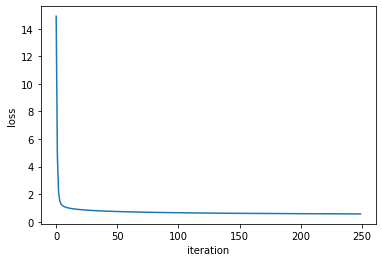

In [377]:
fig, ax = plt.subplots(nrows=1)
ax.plot(loss_tracker)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")

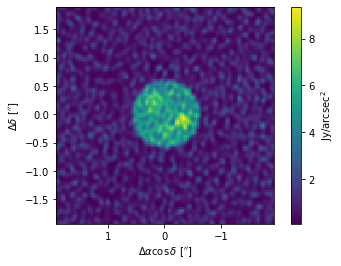

In [382]:
# let's see what one channel of the image looks like
fig, ax = plt.subplots(nrows=1)
img_cube = rml.icube.sky_cube.detach().numpy()
im = ax.imshow(
    np.squeeze(img_cube),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im, label=r"Jy/$\mathrm{arcsec}^2$")
plt.show()